# Анализ напорной кривой ЭЦН

версия 0.1 от 12.5.20


In [1]:
# подготовимся к импорту API который находится в родительской папке относительно этой тетрадки
import sys
sys.path.insert(0,'..')
import pandas as pd
import numpy as np
# импортируем api
import unifloc_vba_python_api.python_api as python_api 
# готовим объект с доступом к надстройке. При этом надстройка откроется и запустится excel 
UniflocVBA = python_api.API("../UniflocVBA_7.xlam")
print("import excel with unifloc vba done. version " + UniflocVBA.unf_version())

import excel with unifloc vba done. version 7.24


In [2]:
import matplotlib.pyplot as plt
#%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 8]

## Описание функций

Анализ проведем с помощью функций с префиксом *ESP* 

`ESP_id_by_rate` - определение id насоса из базы

`ESP_optRate_m3day` - определение оптимального дебита для данного ЭЦН

`ESP_rate_max_sm3day` - определение максимального дебита для данного ЭЦН

`ESP_name` - определение имени по id


Последовательно воспользуемся данными функциями


In [3]:
qliq_nom_m3day = 850
freq_hz = 60

In [4]:
esp_id = UniflocVBA.ESP_id_by_rate(qliq_nom_m3day)
esp_id

755

In [5]:
qliq_opt_m3day = UniflocVBA.ESP_optRate_m3day(freq_hz, esp_id)
qliq_opt_m3day

1200.0

In [6]:
qliq_max_m3day = UniflocVBA.ESP_rate_max_sm3day(freq_hz, esp_id)
qliq_max_m3day

1920.0

In [7]:
esp_name_str = UniflocVBA.ESP_name(esp_id)
esp_name_str

'ЭЦН6-1000'

In [8]:
head_nom_m = 600

In [9]:
num_stages = head_nom_m // UniflocVBA.ESP_head_m(qliq_opt_m3day, pump_id=esp_id)
num_stages

118.0

In [11]:
esp_data = {
    "qliq_m3day":20,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":755,
    "mu_cSt":10,
    "c_calibr":1,
}

# Характеристика ЭЦН на воде
Типичная напорная характеристика ЭЦН

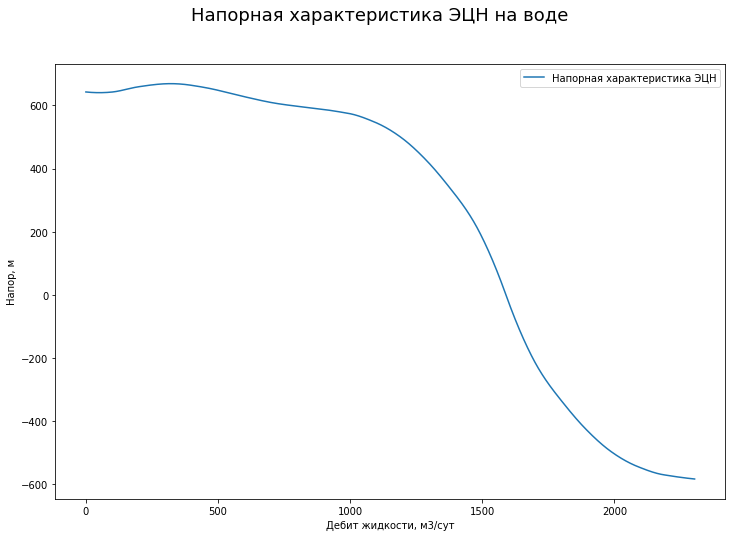

In [12]:
head_list = []
q_list = range(1, int(qliq_max_m3day * 1.2))
for i in q_list:
    this_esp_data = esp_data.copy()
    this_esp_data['qliq_m3day'] = i
    head_list.append(UniflocVBA.ESP_head_m(**this_esp_data))

fig = plt.figure()
plt.plot(q_list,head_list, label = "Напорная характеристика ЭЦН")
plt.legend(loc='upper right')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Напор, м')
fig.suptitle(f"Напорная характеристика ЭЦН на воде", fontsize = 18)
plt.show()

КПД для ЭЦН

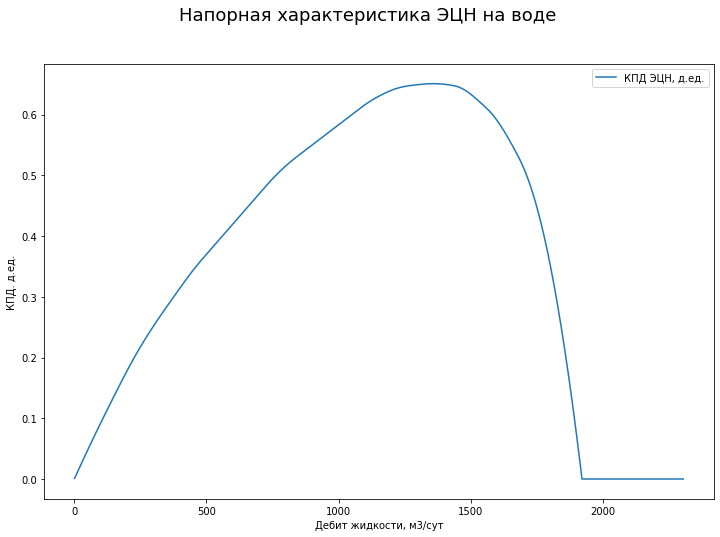

In [13]:
head_list = []
q_list = range(1, int(qliq_max_m3day * 1.2))
for i in q_list:
    this_result = UniflocVBA.ESP_eff_fr(i,
                                        num_stages = num_stages, 
                                        freq_Hz=freq_hz,
                                        pump_id=esp_id
                                        ,
                                        mu_cSt =1  #при -1 не работает, меняются константы класса / используются прошлые констаны?
                                       )
    head_list.append(this_result)

fig = plt.figure()
plt.plot(q_list,head_list, label = "КПД ЭЦН, д.ед.")
plt.legend(loc='upper right')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('КПД. д.ед.')
fig.suptitle(f"Напорная характеристика ЭЦН на воде", fontsize = 18)
plt.show()

Потребляемая мощность

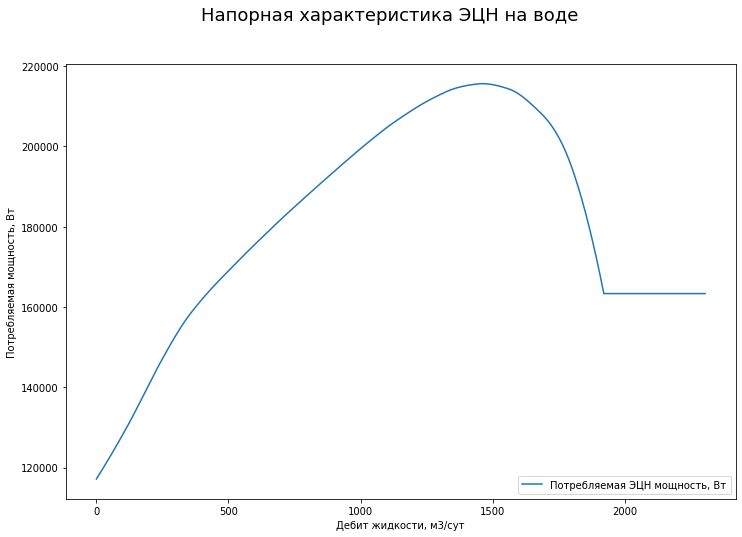

In [14]:
head_list = []
q_list = range(1, int(qliq_max_m3day * 1.2))
for i in q_list:
    head_list.append(UniflocVBA.ESP_power_W(i,num_stages = num_stages, freq_Hz=freq_hz, pump_id=esp_id))

fig = plt.figure()
plt.plot(q_list,head_list, label = "Потребляемая ЭЦН мощность, Вт")
plt.legend(loc='lower right')
plt.xlabel('Дебит жидкости, м3/сут')
plt.ylabel('Потребляемая мощность, Вт')
fig.suptitle(f"Напорная характеристика ЭЦН на воде", fontsize = 18)
plt.show()

Сделаем супер функцию чтобы проще и удобнее было варьировать параметры

In [15]:
def sense_esp(esp_data, parameter_sense, range_sense, qliq_mult_from_max, parameter_to_plot='p_atma', 
              option_sense=0, dimensionless=False):
    """
    esp_data: исходные данные для функций
    parameter_sense: параметр из словаря, который нужно варьровать
    range_sense: список возможных значений параметра
    qliq_mult_from_max: множитель для увеличения ряда дебитов, при 1 последнее значение дебита будет равно максимальному
    qliq_mult_from_max: название параметра для отображения на графиках
    option_sense: тип вызываемой функции,
                    если 0 то UniflocVBA.ESP_head_m, анализ чувствительности для напора ЭЦН
                    если 1 то UniflocVBA.ESP_eff_fr, анализ чувствительности для КПД ЭЦН
                    если 2 то UniflocVBA.ESP_power_W, анализ чувствительности для мощности ЭЦН
    dimensionless: если True, результаты расчетов будут обезразмерены
    """
    fig = plt.figure()
    for i in range_sense:
        esp_data[parameter_sense] = i
        this_qmax_m3day = UniflocVBA.ESP_rate_max_sm3day(esp_data["freq_Hz"], esp_data["pump_id"], esp_data["mu_cSt"])
        
        this_result_list = []
        this_q_liq_range = list(range(1, int(this_qmax_m3day * qliq_mult_from_max),  int(this_qmax_m3day/10)))
        for j in this_q_liq_range:
            esp_data['qliq_m3day']  = j
            if option_sense ==0:
                vba_result = UniflocVBA.ESP_head_m(**esp_data)
            elif option_sense == 1:
                vba_result = UniflocVBA.ESP_eff_fr(**esp_data)
            else:
                vba_result = UniflocVBA.ESP_power_W(**esp_data)
            this_result_list.append(vba_result)
        if dimensionless:
            this_q_liq_range = np.array(this_q_liq_range) / max(this_q_liq_range)
            this_result_list = np.array(this_result_list) / max(this_result_list)
        plt.plot(this_q_liq_range,this_result_list, label = f"{parameter_sense} = {i}")
        
    plt.legend(loc='lower right')
    plt.xlabel("Дебит жидкости")
    plt.ylabel(parameter_to_plot)
    if parameter_sense != 'pump_id':
        fig.suptitle(f"Зависимость {parameter_to_plot} от {parameter_sense} для " 
                     f"{UniflocVBA.ESP_name(esp_data['pump_id'])}", fontsize = 18)
    else:
        fig.suptitle(f"Зависимость {parameter_to_plot} от {parameter_sense} для " 
                     f"различных насосов", fontsize = 18)
        
    plt.show()

# Влияние частоты на работу ЭЦН

In [16]:
esp_data = {
    "qliq_m3day":20,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":755,
    "mu_cSt":10,
    "c_calibr":1,
}

Дебит насоса увеличивается пропорционально увеличению частоты
$$Q_f = Q_{nom}\frac{F}{F_{nom}} $$
Напор насоса увеличивается в квадрате от увеличения частоты
$$H_f = H_{nom}(\frac{F}{F_{nom}})^2 $$

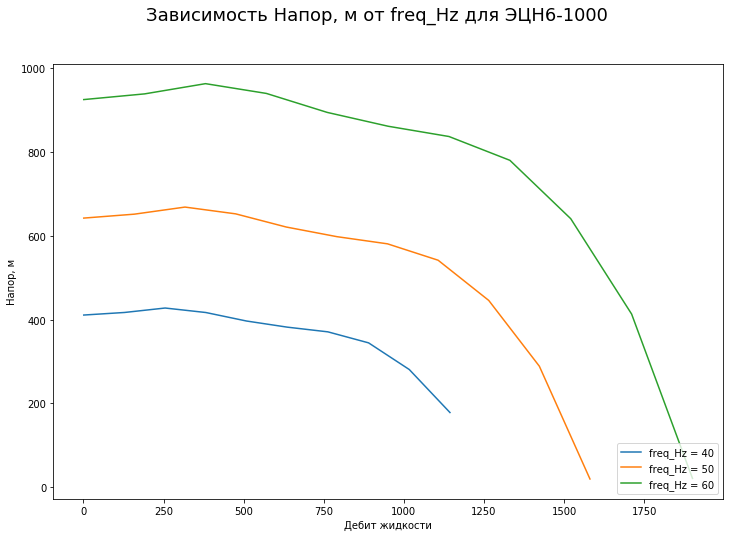

In [17]:
sense_esp(esp_data.copy(), 'freq_Hz', [40, 50, 60], 1, 'Напор, м', 0)

Мощность, потребляемая ЭЦН, увеличивается в 3 степени от частоты
$$N_f = N_{nom}(\frac{F}{F_{nom}})^3 $$

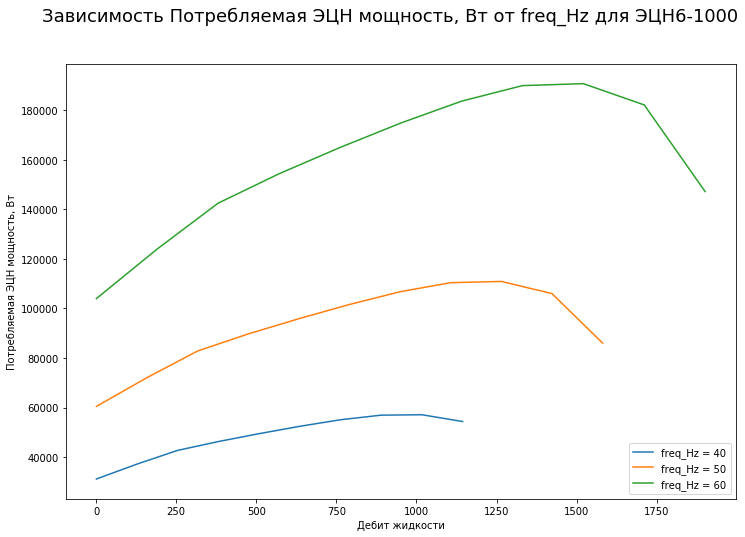

In [18]:
sense_esp(esp_data.copy(), 'freq_Hz', [40, 50, 60], 1, 'Потребляемая ЭЦН мощность, Вт', 2)

КПД, по определению, отношение полезной мощности, переданной перекачиваемой смеси, ко всей потребляемой мощности ЭЦН
$$\eta = \frac{N_{usuful}}{N_{all}}$$

При этом КПД не зависит от частоты
$$\eta_f = \frac{N_{usuful}}{N_{all}} = \frac{Q_f*\Delta P_f}{N_f} = \frac{Q_f*\rho g H_f}{N_f} = \frac{ Q_{nom}\frac{F}{F_{nom}}*\rho g H_{nom}(\frac{F}{F_{nom}})^2 }{ N_{nom}(\frac{F}{F_{nom}})^3} =\frac{Q_{nom}*\rho g H_{nom}}{N_{nom}}$$

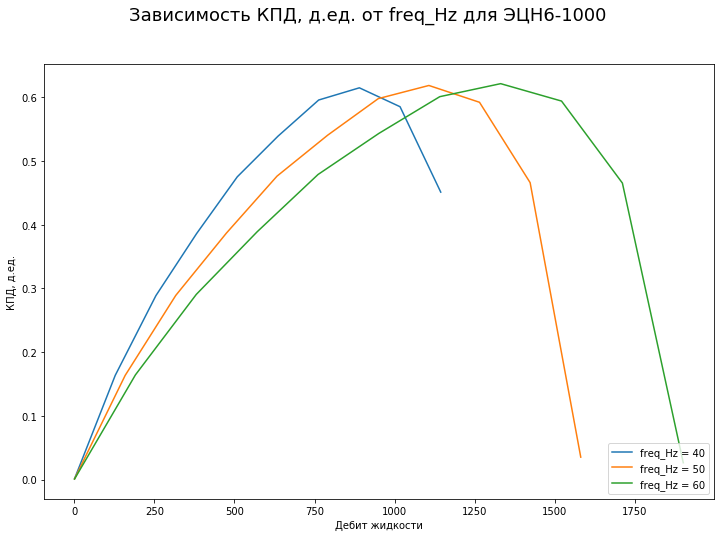

In [19]:
sense_esp(esp_data.copy(), 'freq_Hz', [40, 50, 60], 1, 'КПД, д.ед.', 1)

# Различие ЭЦН

В тестовой базе есть характеристики насосов, которые заданы полиномом n-степени для напора, мощности, кпд

Функция ESP_id_by_rate облегчает выбор насоса
```VBA
    If q > 0 And q < 20 Then ESP_id_by_rate = 738: ' ЭЦН5-15
    If q >= 20 And q < 40 Then ESP_id_by_rate = 740: ' ЭЦН5-30
    If q >= 40 And q < 60 Then ESP_id_by_rate = 1005: ' ЭЦН5-50
    If q >= 60 And q < 100 Then ESP_id_by_rate = 1006: ' ЭЦН5-80
    If q >= 100 And q < 150 Then ESP_id_by_rate = 737: ' ЭЦН5-125
    If q >= 150 And q < 250 Then ESP_id_by_rate = 748: ' ЭЦН5A-200
    If q >= 250 And q < 350 Then ESP_id_by_rate = 750: ' ЭЦН5A-320Ý
    If q >= 350 And q < 600 Then ESP_id_by_rate = 753: ' ЭЦН5À-500
    If q >= 600 And q < 800 Then ESP_id_by_rate = 754: ' ЭЦН5À-700
    If q >= 800 And q < 1200 Then ESP_id_by_rate = 755: ' ЭЦН6-1000
    If q > 1200 Then ESP_id_by_rate = 758
```

Построем характеристики для этих ЭЦН

In [20]:
pump_id_list = [738, 740, 1005, 1006, 737, 748, 750, 753, 754, 755, 758]

In [21]:
esp_data = {
    "qliq_m3day":20,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":755,
    "mu_cSt":10,
    "c_calibr":1,
}

Из-за различной производительности, на одном графике все насосы отобразить трудно

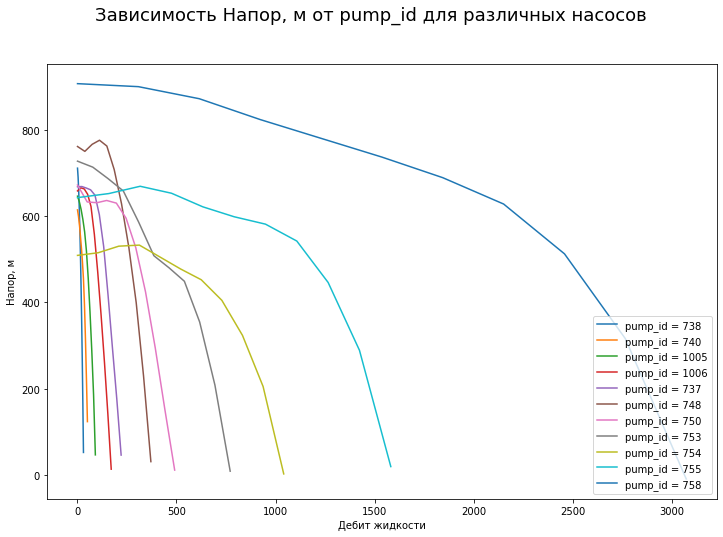

In [22]:
sense_esp(esp_data.copy(), 'pump_id',pump_id_list, 1, 'Напор, м', 0)

После обезразмеривания графиков видно, что форма напорной кривой у каждого насоса своя, за счет конструктивных особенностей

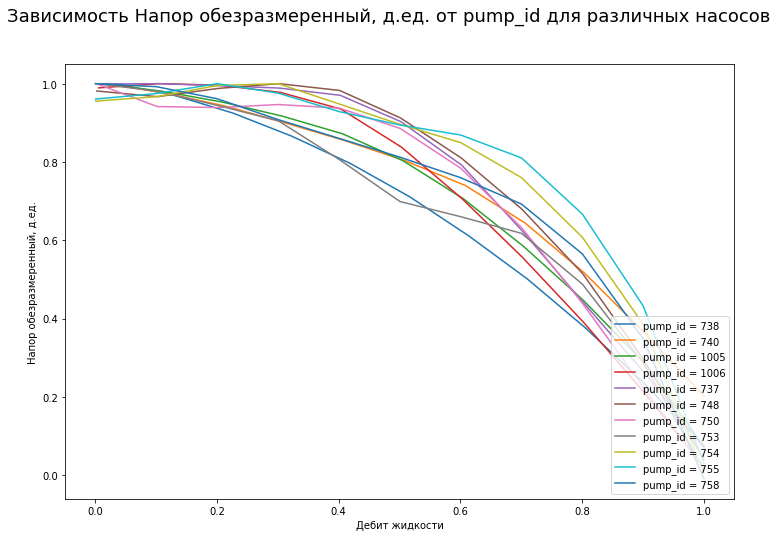

In [23]:
sense_esp(esp_data.copy(), 'pump_id',pump_id_list, 1, 'Напор обезразмеренный, д.ед.', 0, True)

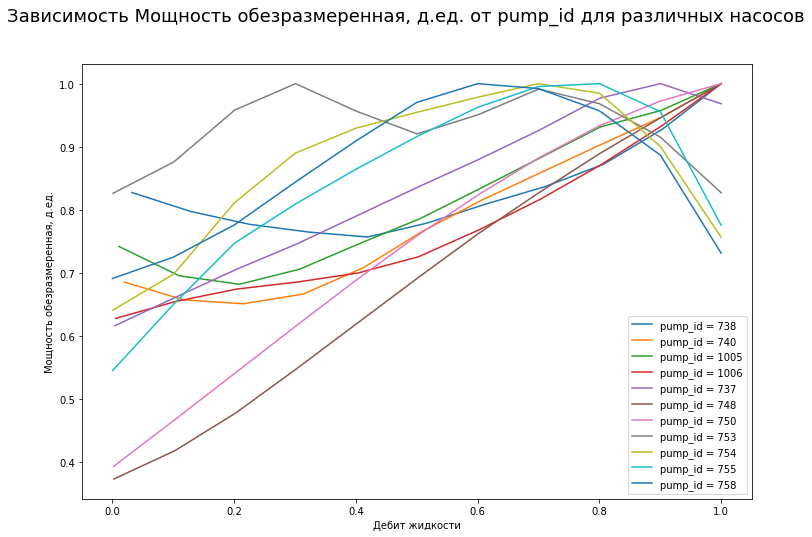

In [24]:
sense_esp(esp_data.copy(), 'pump_id',pump_id_list, 1, 'Мощность обезразмеренная, д.ед.', 2, True)

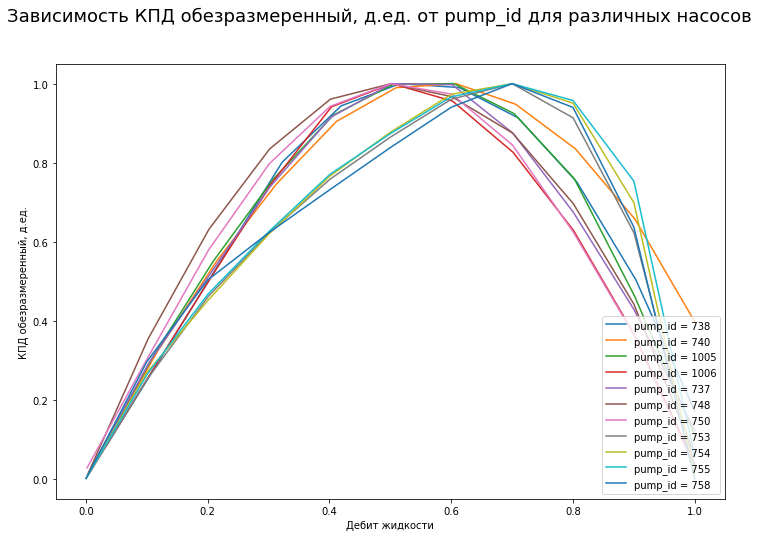

In [25]:
sense_esp(esp_data.copy(), 'pump_id',pump_id_list, 1, 'КПД обезразмеренный, д.ед.', 1, True)

# Влияние вязкости на работу ЭЦН

Очевидно, что вязкость жидкости негативно влияет на работу ЭЦН.

Для учета вязкости используется поправка Института Гидравлики

In [26]:
esp_data = {
    "qliq_m3day":20,
    "num_stages":100,
    "freq_Hz":50,
    "pump_id":755,
    "mu_cSt":10,
    "c_calibr":1,
}

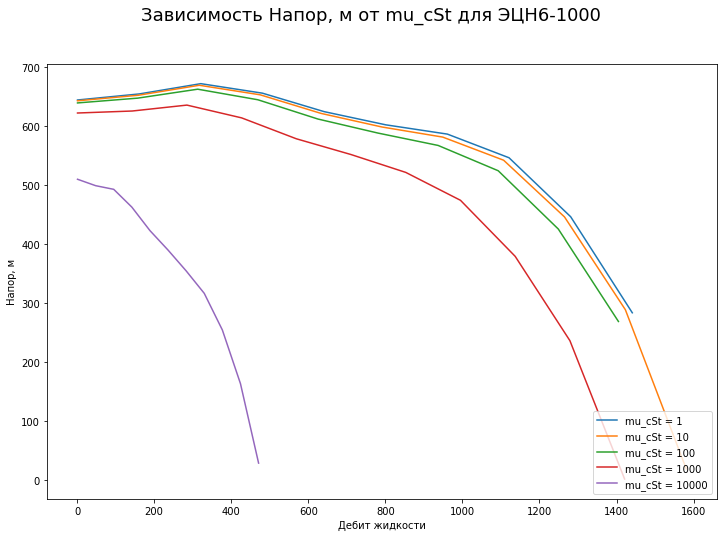

In [27]:
sense_esp(esp_data.copy(), 'mu_cSt', [1, 10, 100, 1000, 10000], 1, 'Напор, м', 0)

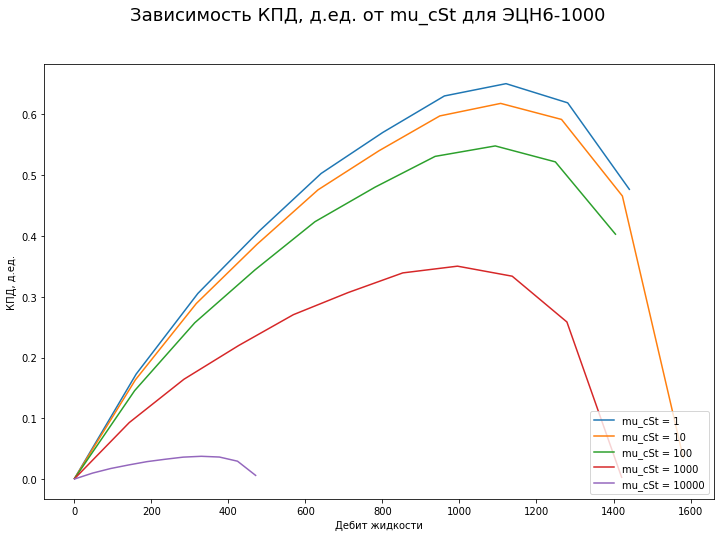

In [28]:
sense_esp(esp_data.copy(), 'mu_cSt', [1, 10, 100, 1000, 10000], 1, 'КПД, д.ед.', 1)

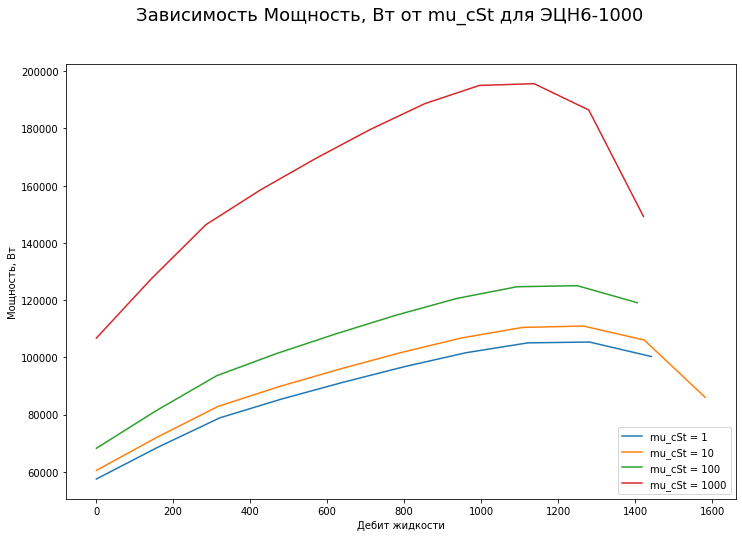

In [29]:
sense_esp(esp_data.copy(), 'mu_cSt', [1, 10, 100, 1000], 1, 'Мощность, Вт', 2)